In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

# Single-GPU Training of GNN for Link Prediction in DGL

In this notebook we will walk through how to train a DGL GNN in self-supvervised fashion through link prediction on the transaction heterograph we created in the last notebook.

It will be easier to understand this notebook if you are familiar with Graph Neural Networks, the concepts of message passing and neighbor sampling and how they are implemented in DGL. Below are some relevant tutorials and references to help you better understand GNNs in DGL. This example is also inspired by the below given tutorials.

## Relevant DGL Tutorials

* [How Does DGL Represent A Graph?](https://docs.dgl.ai/en/latest/tutorials/blitz/2_dglgraph.html#how-does-dgl-represent-a-graph)
* [Working with Heterogenous Graphs in DGL](https://docs.dgl.ai/en/latest/guide/graph-heterogeneous.html?highlight=heterogeneous)
* [Full Graph Link Prediction using Graph Neural Networks (only applicable if you have small graphs)](https://docs.dgl.ai/en/latest/guide/training-link.html)
* [Introduction of Neighbor Sampling for GNN Training](https://docs.dgl.ai/en/latest/tutorials/large/L0_neighbor_sampling_overview.html#sphx-glr-tutorials-large-l0-neighbor-sampling-overview-py)
* [Stochastic Training on Large Graphs](https://docs.dgl.ai/en/latest/guide/minibatch.html)
* [Training GNN with Neighbor Sampling for Node Classification](https://docs.dgl.ai/en/latest/tutorials/large/L1_large_node_classification.html)
* [Stochastic Training of GNN for Link Prediction](https://docs.dgl.ai/en/latest/tutorials/large/L2_large_link_prediction.html)
* [Training GNN for Link Prediction with Neighborhood Sampling](https://docs.dgl.ai/en/latest/guide/minibatch-link.html#guide-minibatch-link-classification-sampler)

## Relevant References

* [GCN Paper](https://tkipf.github.io/graph-convolutional-networks/)
* [R-GCN Paper](https://arxiv.org/abs/1703.06103)
* [GraphSage Paper](https://cs.stanford.edu/people/jure/pubs/graphsage-nips17.pdf)
* [Graph Based Fraud Detection Papers](https://github.com/safe-graph/graph-fraud-detection-papers)

In [1]:
import os
import numpy as np
import dgl

import torch
from tqdm import tqdm 

device = torch.device('cuda')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


## Graph ML Tasks

Learning tasks in Graph ML can be looked at node-level, edge-level or the whole graph-level. These include:

* **Node-Level Tasks**
    * **Node classification:** Predict a property/class of a node
        * Example: Categorize online users / items
* **Edge-Level Tasks**
    * **Link prediction:** Predict whether there are missing links between two nodes
        * Example: Knowledge graph completion
    * **Edge Regression/Classification:** Predict/classify some attribute of edges
* **Graph-Level Tasks**
    * **Graph classification:** Categorize different graphs
        * Example: Molecule property prediction
    * **Community Detection/Clustering:** Detect if nodes form a community
        * Example: Social circle detection
    * **Graph generation:** Drug discovery
    * **Graph evolution:** Physical simulation

Additionally, the node/edge features that we learn from performing Graph ML tasks can be used as additional features in downstream models.

We will be focusing on Link Prediction in this example so let's learn more about that.

## About Link Prediction

The objective of link prediction is to predict whether an edge exists between two given nodes. 

A GNN-based link prediction model represents the likelihood of connectivity between two nodes $u$ and $v$ through a score $y_{uv} = \phi(\boldsymbol{h}^{(L)}_u, \boldsymbol{h}^{(L)}_v)$ that is a function of of $\boldsymbol{h}^{(L)}_u$ and $\boldsymbol{h}^{(L)}_v$ their final layer node representations computed from the multi-layer GNN.

Training a link prediction model involves comparing the scores of real edges against that of a "non-existent" or arbitrary edges. In this case, given an edge connecting card $u$ and merchant $v$, we encourage the score between nodes u and v to be higher than the score between node u and an arbitrarily sampled merchant node $v′$. Such methodology is called negative sampling.

Ultimately, we can formulate the problem as binary classification so we can use the usual classification loss functions like Cross-Entropy Loss, Maximum-Margin loss, etc.

Today we will be using cross-entropy loss in this example.

## Link Prediction is Self-Supervised Learning
Link prediction itself is already useful in various tasks such as recommendations where you will predict whether a node will interact with another node.

It's easy to see how with the help of negative sampling Link Prediction is a representation learning method where a supervised task is created out of the unlabelled data. So it can be thought of as a form of self-supervised [contrastive learning](https://towardsdatascience.com/understanding-contrastive-learning-d5b19fd96607) that doesn't require external annotations or labels for our data. This makes it really useful in an learning setting as a pre-training task to learn a latent representation of all the nodes.

The learned representations of cards and merchants could then be used for downstream tasks such as

* fraud detection
* chargeback prediction
* anomaly detection

With that brief introduction to Link Prediction we are ready to dive into the notebook. 

## Load Transaction Graph

First let's use the `load_graphs` function in DGL to load the transaction heterograph we created at the end of Notebook 1

In [2]:
BASE_DIR = "./basedir"
processed_path = os.path.join(BASE_DIR, "processed_data_1gpu")

In [3]:
g = dgl.load_graphs(os.path.join(processed_path, 'transaction_graph.bin'))[0][0]

In [4]:
g

Graph(num_nodes={'card': 4782, 'merchant': 93298},
      num_edges={('card', 'transaction', 'merchant'): 24198836, ('merchant', 'transaction-rev', 'card'): 24198836},
      metagraph=[('card', 'merchant', 'transaction'), ('merchant', 'card', 'transaction-rev')])

Recall we have two kinds of nodes in our Heterograph, `card` and `merchant`. We have two types of edges: `transaction` and its reverse edge `transaction-rev` which we added to make the graph bidirectional and enable message passing from cards to merchants and vice-versa. And we are trying to perform link prediction on the `transaction` edge.

## Setting up Link Prediction


Setting up the link prediction task is tricky especially because we need to create the labels and dataset
splits on our own. Concretely, we need to hide some edges from the GNN and the let the GNN predict if the edges exist. DGL provides  [`EdgeDataLoader`](https://docs.dgl.ai/en/latest/api/python/dgl.dataloading.html#dgl.dataloading.pytorch.EdgeDataLoader) which allows you to iterate over edges in batches for edge classification or link prediction tasks and feed mini-batches into our GNN. To fully appreciate EdgeDataLoader's functionality it's useful to first understand some basic concepts.

### Message and Supervision Edges

Usually, for edge level tasks like link prediction, edge classification/regression we assign two types of edge in the graph: Supervision Edges and Message edges. The Supervision edges are what get sampled in the minibatch by DGL's EdgeDataLoader and as we will be trying to make predictions for these edges they are not fed into GNN and do not take part in message passing. Mesage Edges (i.e. the remaining edges that didn't get sampled in the minibatch) on the other hand are used for message passing so they are fed into GNN.
 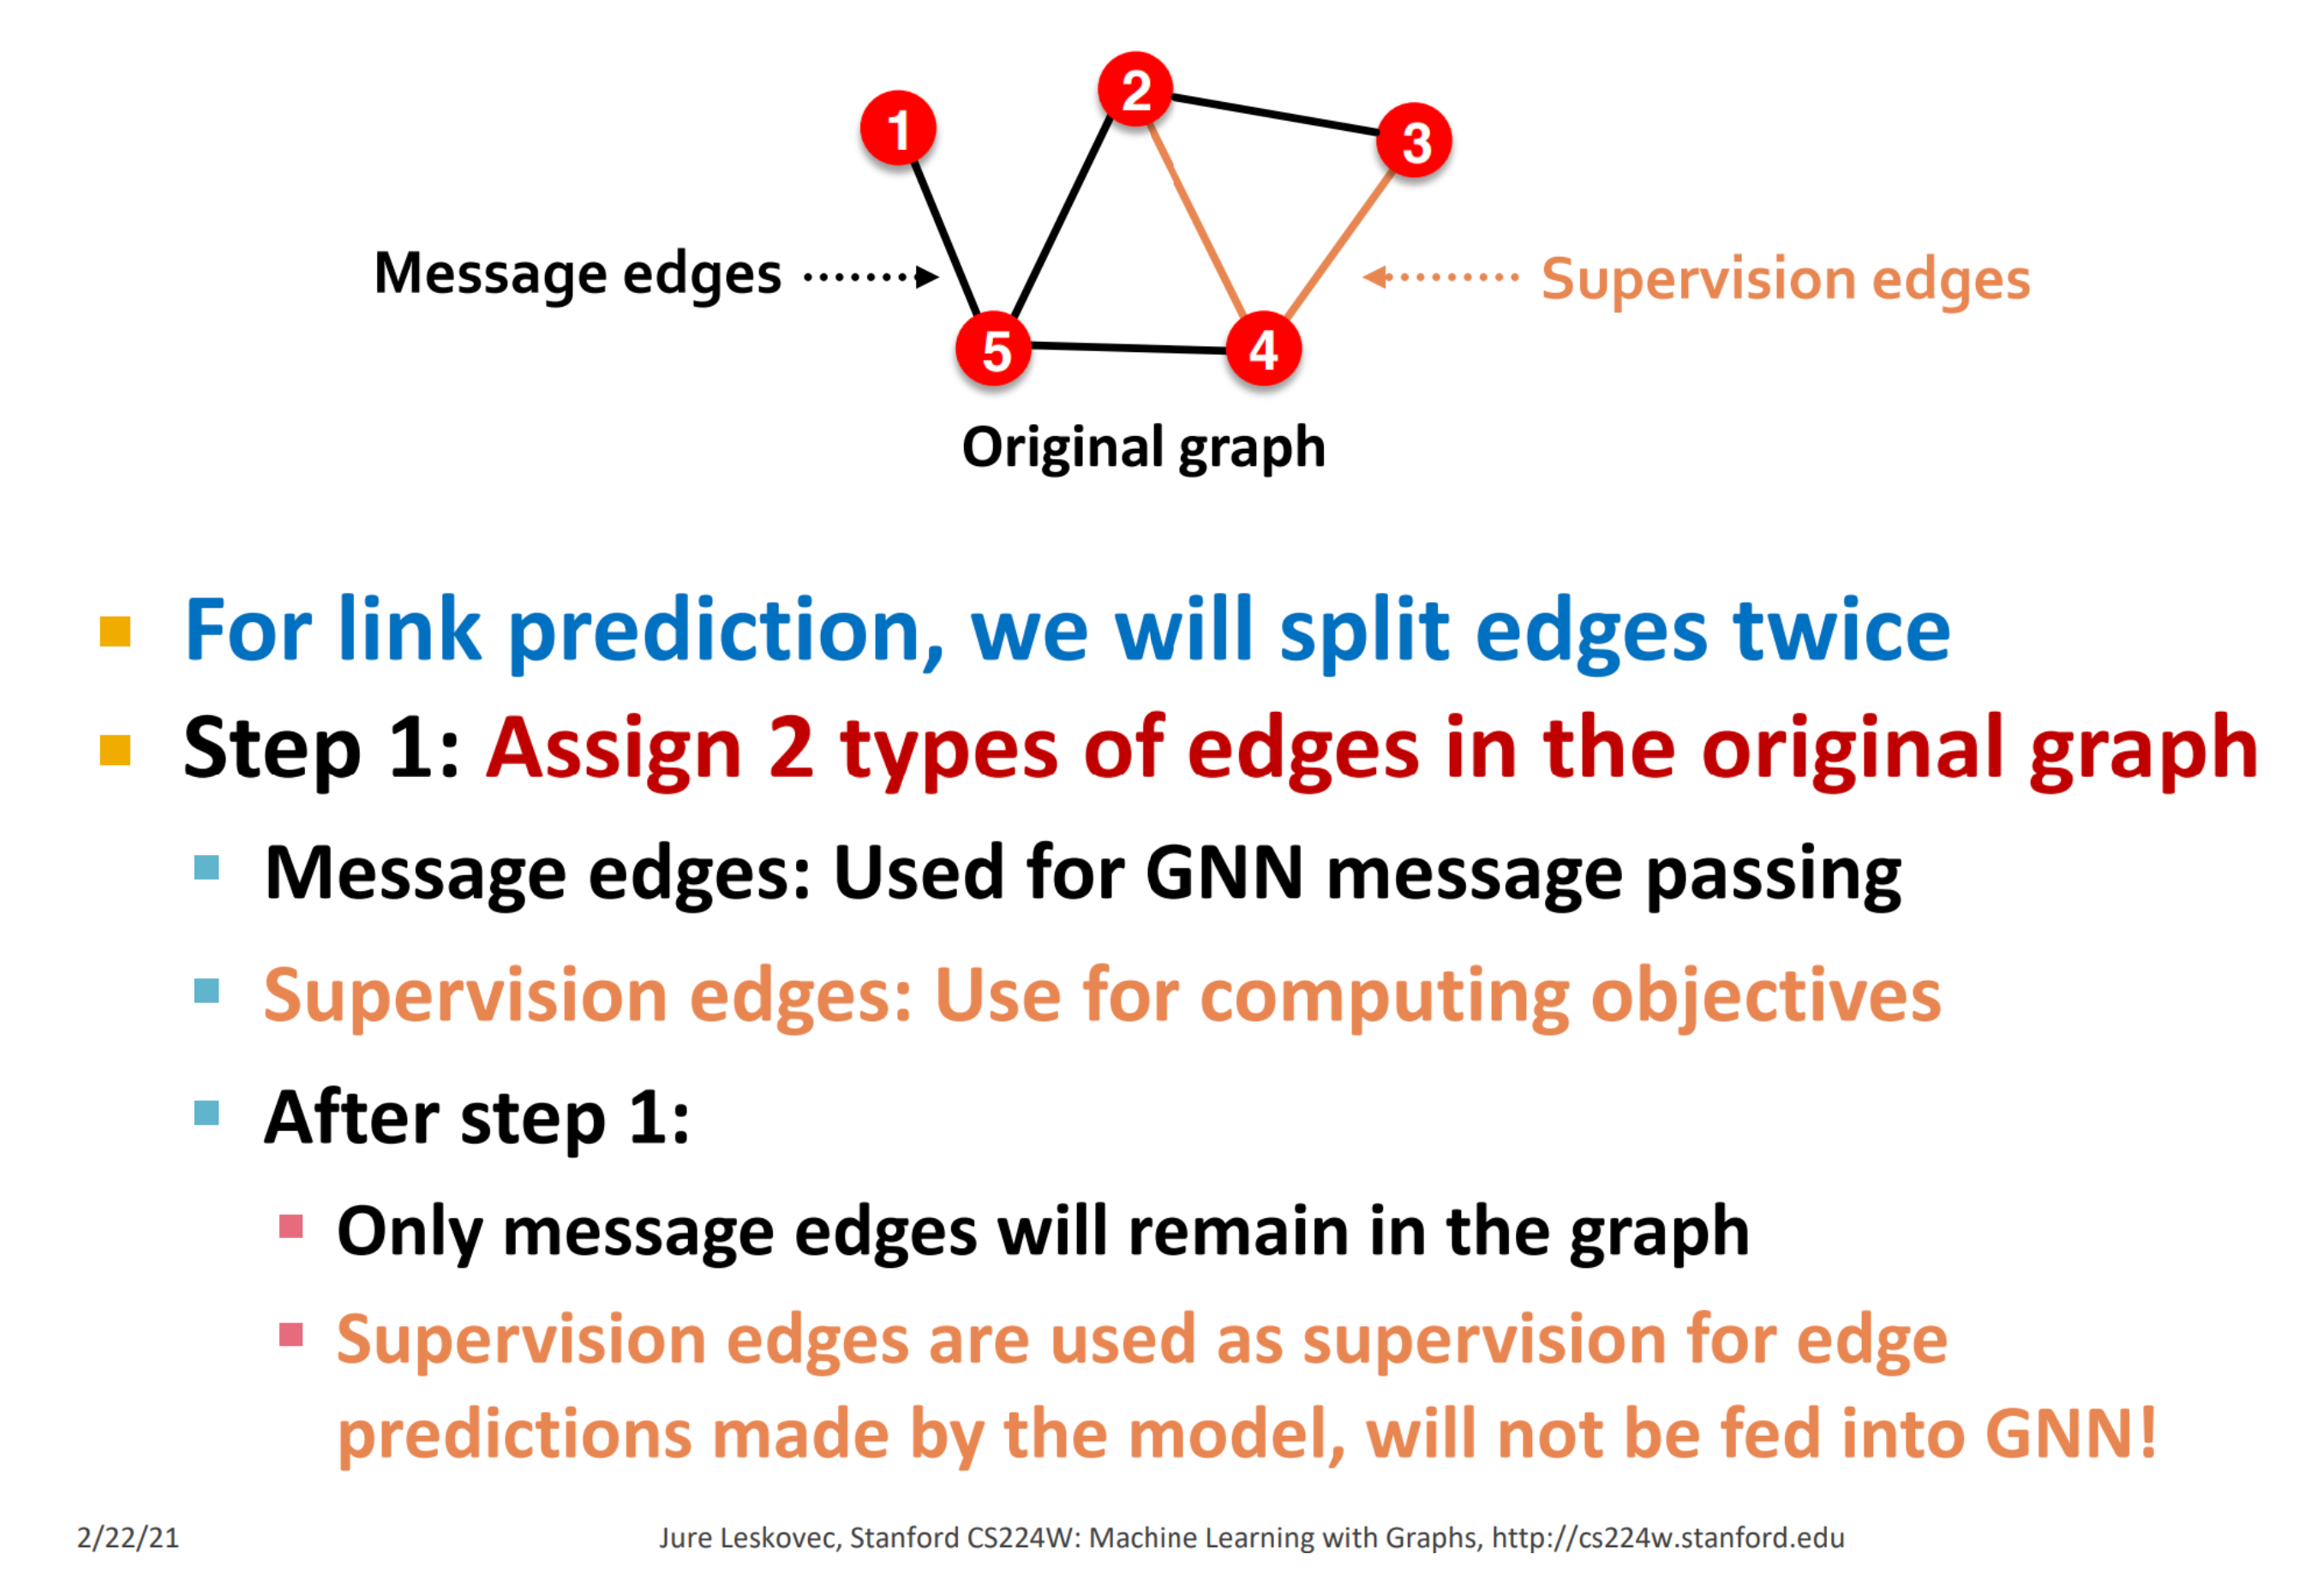

### Train-Test Split

There's two types of link prediction splits.

First type is inductive split where the graph will be split into 3 independent graphs: one for train, one for validation and one for test. In train or val or test set, each graph will have 2
types of edges: message edges + supervision edges.

Second one is Transductive which is the default setting when people talk about link prediction and what we will be doing in this example . By definition of “transductive”, the entire original graph can be observed in all dataset splits. But since edges are both part of graph structure and the supervision, we need to hold out validation / test edges. To train the training set, we further need to hold out supervision edges for the training set.

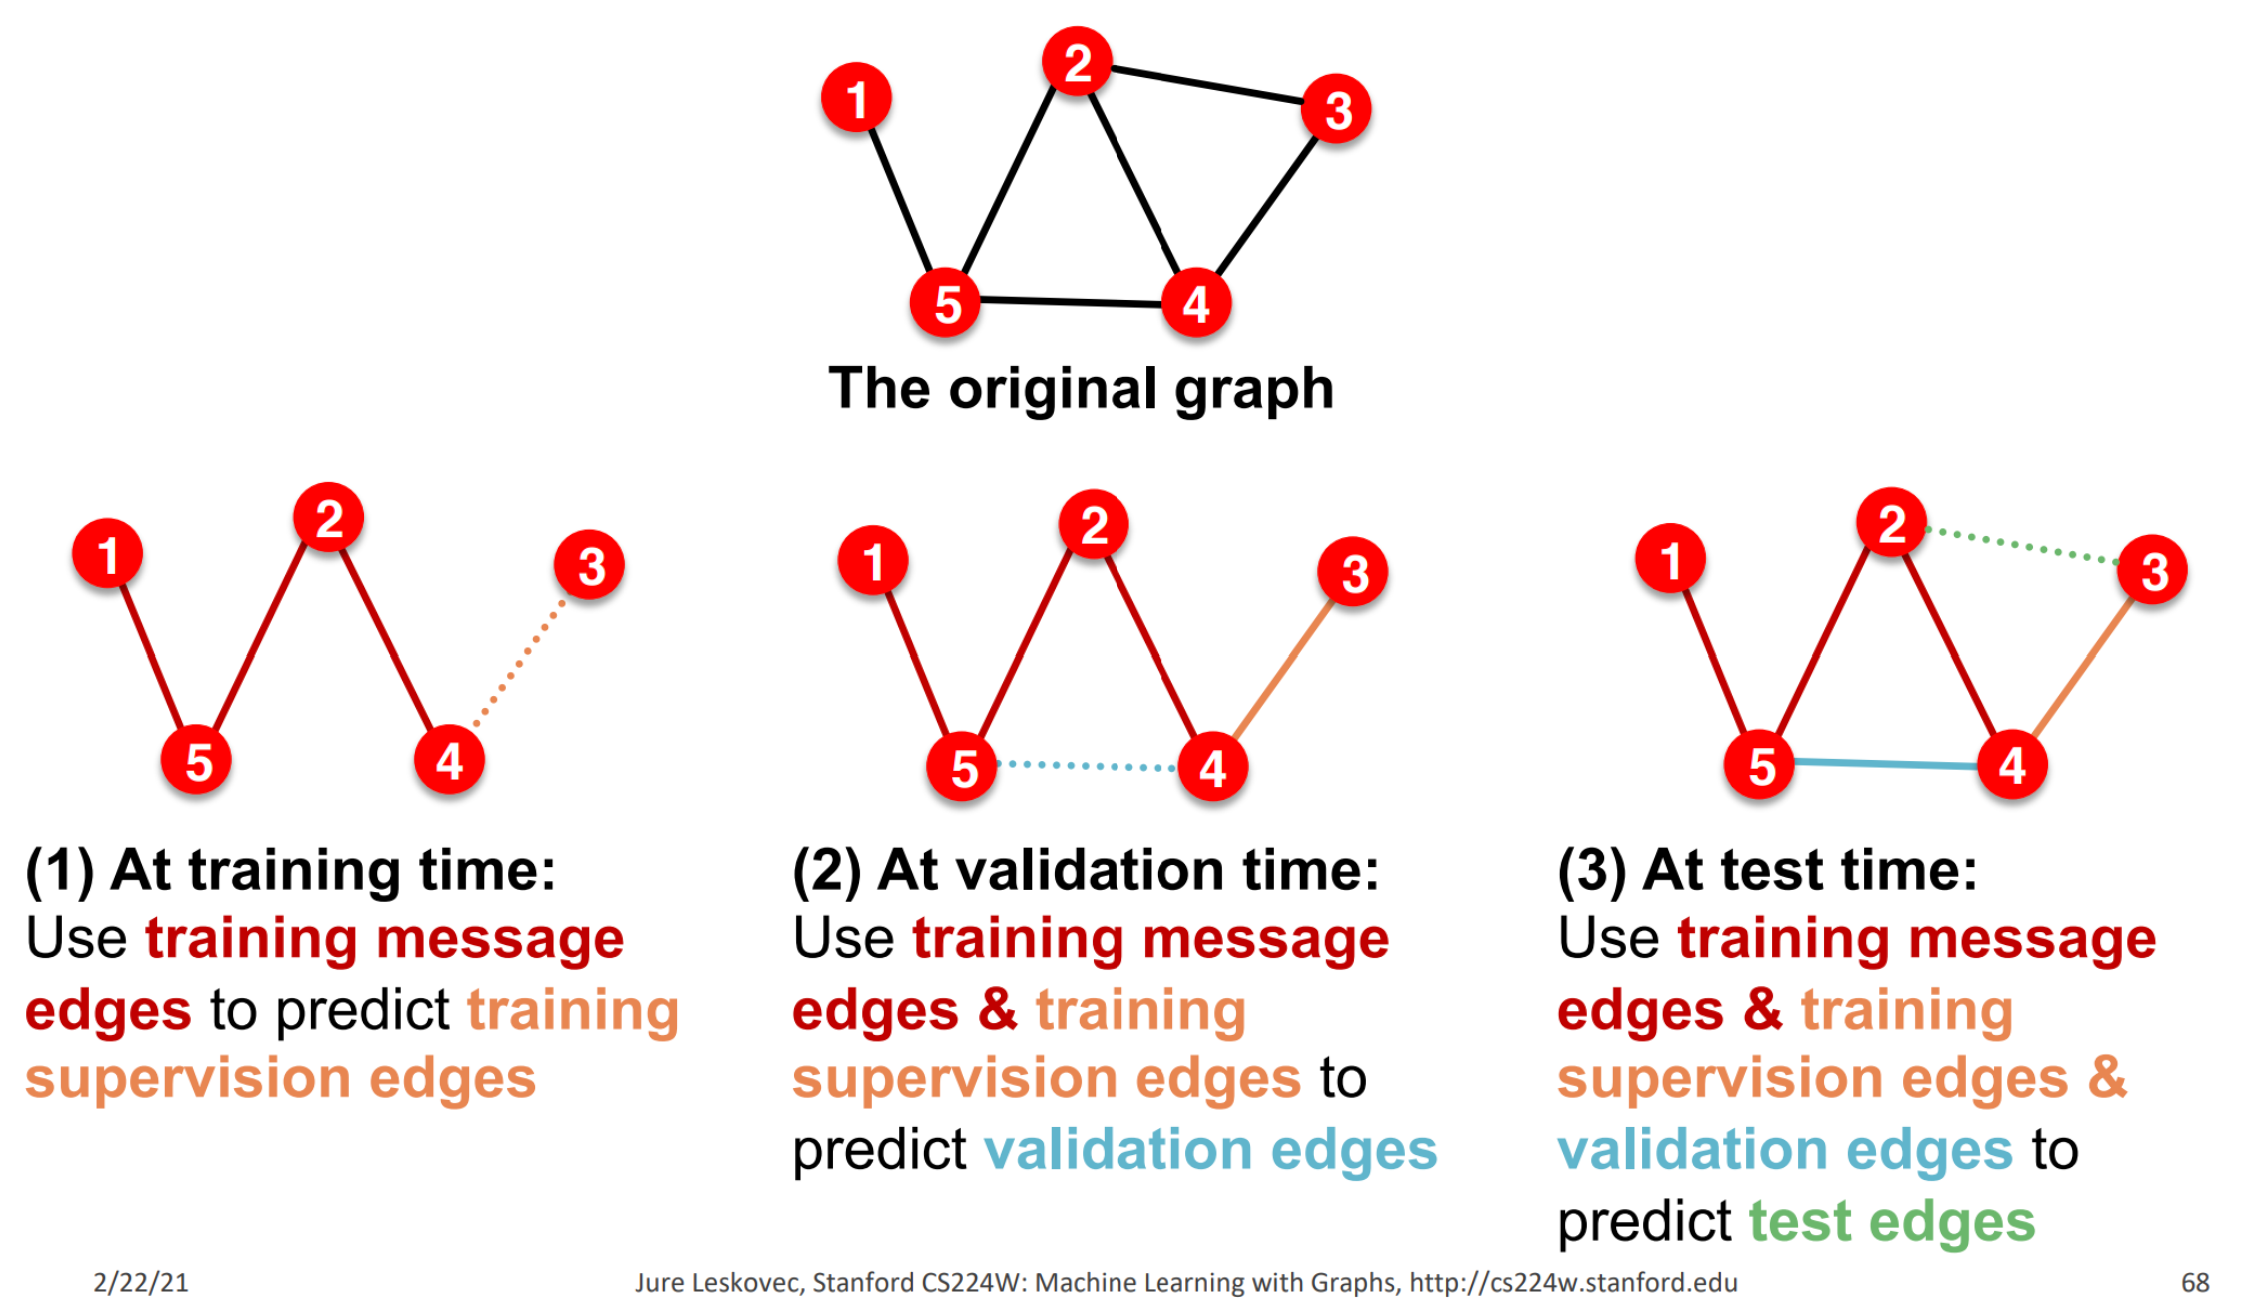

At training time we use training message edges to predict training supervision edges. At validation time we use training message edges and training supervision edges to predict validation edges. Finally, at test time we use training message edges and training supervision edges and validation edges to predict test edges. 

**Why do we use growing number of edges?** After training, supervision edges are known to GNN.
Therefore, an ideal model should use supervision
edges in message passing at validation time.
The same applies to the test time.

In [5]:
# we only perform link pred on transaction etype 
link_pred_etype = ('card', 'transaction', 'merchant')
train_mask = g.edata['train_mask'][link_pred_etype].bool()
test_mask = g.edata['test_mask'][link_pred_etype].bool()

num_edges = g.num_edges(etype='transaction')
all_edges = torch.arange(num_edges)
train_edges = all_edges[train_mask]
test_edges = all_edges[test_mask]

Here, in this example we only show training and test set but for model selection and hyperparameter tuning we recommend also creating a validation set. Now let's create the training graph as a subgraph of the original graph to hold out the test edges from taking part in message passing at train time.

In [6]:
# g_train only includes train edges
g_train = dgl.edge_subgraph(graph=g,
                            edges={'transaction' : train_edges,
                                  'transaction-rev': train_edges},
                            relabel_nodes=False)

Now let's quickly talk about the next big component of `EdgeDataLoader` which is neighbor sampling. 

### Neighbor Sampling

For large graphs with, say, millions or even billions of nodes or edges, usually full-graph training would not work. This is because taking all neighbors for message aggregation is often too costly since the nodes needed for input features would easily cover a large portion of the graph, especially for real-world graphs which are often [scale-free](https://www.wikiwand.com/en/Scale-free_network).

[Neighbor sampling](https://docs.dgl.ai/en/latest/guide/minibatch.html?highlight=neighbor%20sampling) addresses this issue by selecting a subset of the neighbors to perform aggregation.

Neighborhood sampling methods generally work as the following. For each gradient descent step, we select a minibatch of nodes whose final representations at the $\boldsymbol{L}$-th layer are to be computed. We then take all or some of their neighbors at the $\boldsymbol{L−1}$ layer. This process continues until we reach the input. This iterative process builds the dependency graph starting from the output and working backwards to the input, as the figure below shows:

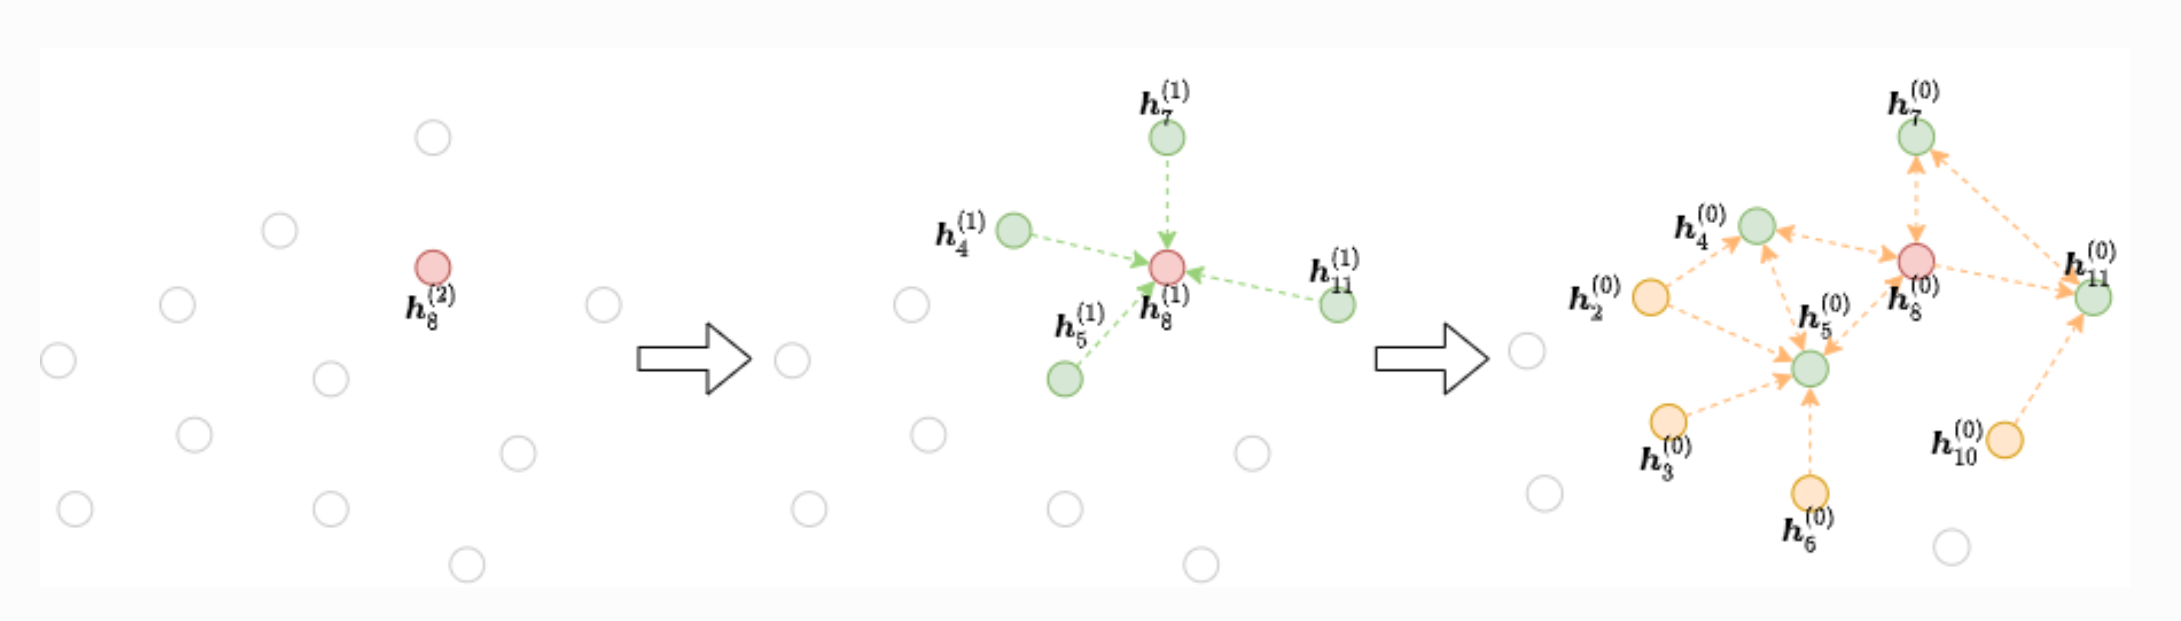

DGL provides a few neighborhood samplers and a pipeline for training a GNN with neighborhood sampling, as well as ways to customize your sampling strategies.

We will be using a basic neighbor sampler, namely, DGL's [`MultiLayerNeighborSampler`](https://docs.dgl.ai/en/latest/api/python/dgl.dataloading.html?highlight=multilayerneighborsampler#dgl.dataloading.neighbor.MultiLayerNeighborSampler) here in this example. This builds computational dependency of node representations via neighbor sampling for multilayer GNN. This sampler will make every node gather messages from a fixed number of neighbors per edge type. The neighbors are picked uniformly. We can specify the number of neighbors to uniformly sample per edge type for each GNN layer, starting from the first layer through the `fanouts` parameter. If the graph is heterogenous we can pass in a dict specifying the number of neighbors to sample for each edge type/node type. 

Since the card and merchant nodes' in-degrees are highly skewed we will use the median card in-degree i.e. how many unique merchants does a typical card shop at as the fan-out for neighbor sampling. Similarly for the merchant nodes we will use the median card in-degree as the fanout for neighbor sampling.

In [7]:
median_card_in_deg = torch.median(g.in_degrees(etype='transaction-rev')).item()

median_merch_in_deg = torch.median(g.in_degrees(etype='transaction')).item()

print("Median in-degree of card nodes is", median_card_in_deg)

print("Median in-degree of merchant nodes is", median_merch_in_deg)

Median in-degree of card nodes is 3735
Median in-degree of merchant nodes is 5


In this example, here we will be training a 2-layer GNN.

In [8]:
num_layers = 2
neigh_sampler = dgl.dataloading.MultiLayerNeighborSampler([
     {('card', 'transaction', 'merchant'): median_merch_in_deg,
     ('merchant', 'transaction-rev', 'card'): median_card_in_deg}] * num_layers)

To customize your neighbor sampler check out this [tutorial.](https://docs.dgl.ai/en/latest/guide/minibatch-custom-sampler.html)

### Negative Sampler

To train the link prediction model, we will be showing our model examples of both positive edges (ones that actually exist) and negative edges (ones that don't actually exist) and so we also need to provide a negative sampler to generate the negative edges. Here we use the builti-in Uniform negative sampler. For every sampled `transaction` edge this negative sampler will create `k` (here we use `k=1`) negative edges by pairing up the source card node of the sampled `transaction` edge with a randomly uniformly sampled merchant node. The negative sampler does not ensure that the negative edge it creates is not an actual edge but for large graphs this is typically not a problem.

In [9]:
neg_sampling_k = 1
neg_sampler = dgl.dataloading.negative_sampler.Uniform(neg_sampling_k)

#### Customizing Negative Sampling

**Note:** You can also give your own negative sampler function, as long as it takes in the original graph g and the minibatch edge ID array eid, and returns a pair of source ID arrays and destination ID arrays.

The following code gives an example of custom negative sampler that samples negative destination nodes according to a probability distribution proportional to a power of degrees.

In [10]:
class NegativeSampler(object):
    def __init__(self, g, k):
        # caches the probability distribution
        self.weights = g.in_degrees().float() ** 0.75
        self.k = k

    def __call__(self, g, eids):
        src, _ = g.find_edges(eids)
        src = src.repeat_interleave(self.k)
        dst = self.weights.multinomial(len(src), replacement=True)
        return src, dst

We will stick with the DGL-provided Uniform Negative Sampler for this example.

So to recap for link prediction on large graphs, we need to 
* iterate over batch of edges and perform neighbor sampling
* sample negative edges to assign negative scores for the loss

before computing the output representation of incident nodes of all sampled edges using the GNN.

### Train EdgeDataLoader

Now we are ready to define the training EdgeDataLoader for our example.

In [11]:
# specify batch size
batch_size = 8192

train_dataloader = dgl.dataloading.EdgeDataLoader(
    g=g_train, 
    eids={'transaction' : torch.arange(g_train.num_edges(etype='transaction'))},
    block_sampler=neigh_sampler,
    exclude='reverse_types',
    reverse_etypes={'transaction': 'transaction-rev',
                    'transaction-rev': 'transaction'},
    negative_sampler=neg_sampler,
    batch_size=batch_size,
    device=device,
    shuffle=True, # pytorch dataloader arguments
    drop_last=False, #
    num_workers=0) #

Here we specify 
* `g_train` as the graph where we want to sample supervision edges from,
* `eids` is the set of edges we want to sample supervision edges from. Here we specify it as the set of all edges in `g_train` ,
* `neigh_sampler` as our neighbor sampler,
* `exclude` and `reverse_etypes` is how we ensure that our supervision edges (the edges sampled in the minibatch) and their reverse edges are not fed as input into GNN and and that they don't take part in message passing. This way only message edges (i.e. all the edges that didn't get sampled in the minibatch) are used for message passing and supervision edges are not.
* `device` as GPU. This way even though the neighbor sampling takes place on the CPU is the minibatch is directly put on the GPU

We can peek at one minibatch from `train_dataloader` and see what it gives.

In [12]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch[0])
print("\n", example_minibatch[1])
print("\n", example_minibatch[2])
print("\n", example_minibatch[3])

{'card': tensor([2919, 4271, 2682,  ...,  670, 2472, 2858], device='cuda:0'), 'merchant': tensor([15600,    20, 12690,  ..., 56222, 92178, 20508], device='cuda:0')}

 Graph(num_nodes={'card': 3073, 'merchant': 9813},
      num_edges={('card', 'transaction', 'merchant'): 8192, ('merchant', 'transaction-rev', 'card'): 0},
      metagraph=[('card', 'merchant', 'transaction'), ('merchant', 'card', 'transaction-rev')])

 Graph(num_nodes={'card': 3073, 'merchant': 9813},
      num_edges={('card', 'transaction', 'merchant'): 8192, ('merchant', 'transaction-rev', 'card'): 0},
      metagraph=[('card', 'merchant', 'transaction'), ('merchant', 'card', 'transaction-rev')])

 [Block(num_src_nodes={'card': 4700, 'merchant': 86603},
      num_dst_nodes={'card': 4369, 'merchant': 75035},
      num_edges={('card', 'transaction', 'merchant'): 280149, ('merchant', 'transaction-rev', 'card'): 12097406},
      metagraph=[('card', 'merchant', 'transaction'), ('merchant', 'card', 'transaction-rev')]), Block

The example minibatch consists of four elements.

* The **input nodes** necessary for computing the representation of output nodes. By output nodes we mean all the incident nodes (i.e. source and destination nodes) of all the sampled edges (also called as positive edges) as well as negative edges.
* **Positive Subgraph:** The subgraph induced by the as the edges sampled in the minibatch (also called as positive edges)
* **Negative Subgraph:** The subgraph induced by the non-existent edges sampled by the negative sampler.
* The list of **message flow graphs** (also called blocks), one for each layer. These are special DGL bipartite graphs created by the `EdgeDataLoader` and store the computational graph showing how messages should flow among the the minibatch nodes for each layer. To learn more about message flow graphs/blocks check out this [tutorial.](https://docs.dgl.ai/tutorials/large/L0_neighbor_sampling_overview.html?highlight=message%20flow)

In [13]:
input_nodes, pos_graph, neg_graph, blocks = example_minibatch
print('Number of card nodes in input nodes:', len(input_nodes['card']))
print('Number of merchant nodes in input nodes:', len(input_nodes['merchant']))
print('Positive graph # nodes:', pos_graph.number_of_nodes(), '# edges:', pos_graph.number_of_edges())
print('Negative graph # nodes:', neg_graph.number_of_nodes(), '# edges:', neg_graph.number_of_edges())
print("List of Message Flow Graphs (Blocks):\n", blocks)

Number of card nodes in input nodes: 4700
Number of merchant nodes in input nodes: 86603
Positive graph # nodes: 12886 # edges: 8192
Negative graph # nodes: 12886 # edges: 8192
List of Message Flow Graphs (Blocks):
 [Block(num_src_nodes={'card': 4700, 'merchant': 86603},
      num_dst_nodes={'card': 4369, 'merchant': 75035},
      num_edges={('card', 'transaction', 'merchant'): 280149, ('merchant', 'transaction-rev', 'card'): 12097406},
      metagraph=[('card', 'merchant', 'transaction'), ('merchant', 'card', 'transaction-rev')]), Block(num_src_nodes={'card': 4369, 'merchant': 75035},
      num_dst_nodes={'card': 3073, 'merchant': 9813},
      num_edges={('card', 'transaction', 'merchant'): 36019, ('merchant', 'transaction-rev', 'card'): 9573392},
      metagraph=[('card', 'merchant', 'transaction'), ('merchant', 'card', 'transaction-rev')])]


### Test EdgeDataLoader

`MultiLayerFullNeighborSampler` is what we use for the test data loader. 

In [14]:
test_eid_dict = {'transaction' : test_edges}
full_sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers=num_layers)
test_batch_size = 81920*2
test_dataloader = dgl.dataloading.EdgeDataLoader(
    g=g,
    eids=test_eid_dict,
    block_sampler=neigh_sampler,
    device=device,
    g_sampling=g_train,
    negative_sampler=neg_sampler,
    batch_size=test_batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0)

Here we specify 
* original graph `g` as the graph where we want to sample test edges from,
* `eids` is the set of edges we want to sample test edges from. Here we specify it as the set of all test edges in original graph `g` ,
* `full_sampler`, the full neighbor sampler as our neighbor sampler,
* `g_sampling` as the graph where neighbor sampling and message passing should be done. Here we specify it as `g_train_val` the graph consisting of training and validation edges. This ensures that at test time we use training message edges and training supervision edges and validation edges to predict test edges.
* `device` as GPU. This way even though the neighbor sampling takes place on the CPU is the minibatch is directly put on the GPU

If you wanted to get rid of stochasticness in test/validation evaluation introduced by neighbor sampling you could try using [`MultiLayerFullNeighborSampler`](https://docs.dgl.ai/en/latest/api/python/dgl.dataloading.html?highlight=multilayerfull#dgl.dataloading.neighbor.MultiLayerFullNeighborSampler) instead of the `MultiLayerNeighborSampler`.`MultiLayerFullNeighborSampler` sampler builds computational dependency of node representations by taking messages from all neighbors for multilayer GNN. So this sampler will make every node gather messages from every single neighbor per edge type.

## Define GNN for Node Representation

The GNN we will be using is basic 2-layer GNN GraphSage model and since we have a heterogenous graph we will use the `HeterGraphConv` layer in DGL to implement a Heterogenous GraphSage. We use the mean aggregation in GraphSage. Other supported aggregations include `max`, `lstm` and `gcn`. We also use dropout after the first GNN layer and define the GNN as follows:

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class HeteroGraphSage(nn.Module):
    def __init__(self, n_input, n_hidden, n_out, n_layers, rel_names, agg='mean', dout=0.5, activation=F.relu):
        super().__init__()
      
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        self.activation = activation
        self.agg = agg
        self.dout = dout
  
        self.layers.append(dglnn.HeteroGraphConv({
            rel: dglnn.SAGEConv(self.n_input, self.n_hidden,
                                aggregator_type=self.agg,
                                feat_drop=self.dout,
                                activation=self.activation)
            for rel in rel_names}))

            
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.HeteroGraphConv({
                rel: dglnn.SAGEConv(n_hidden, n_hidden,
                                    aggregator_type=self.agg,
                                    feat_drop=self.dout,
                                    activation=self.activation)
                for rel in rel_names}))

        self.layers.append(dglnn.HeteroGraphConv({
            rel: dglnn.SAGEConv(self.n_hidden, self.n_out,
                                aggregator_type=self.agg)
            for rel in rel_names}))

    def forward(self, blocks, x):
        for layer, block in (zip(self.layers, blocks)):
            x = layer(block, x)
        return x

## Define the Score Predictor for Edges

To compute the score for a potential edge we take the dot product of the representations of its incident nodes.  

This can be easily accomplished with `apply_edges` method.

In [16]:
class ScorePredictor(nn.Module):
    def __init__(self, score_etype):
        super().__init__()
        self.score_etype = score_etype
        
    def forward(self, edge_subgraph, h):
        with edge_subgraph.local_scope():
            edge_subgraph.ndata['h'] = h
            edge_subgraph.apply_edges(dgl.function.u_dot_v('h', 'h', 'score'), etype=self.score_etype)
            score = edge_subgraph.edata['score'][self.score_etype].squeeze(1)
            return score

## Define the Link Prediction Model

We now define the `LinkPredictor` model made up of GNN to compute the node representations and score predictor to score th edges.

In [17]:
class LinkPredictor(nn.Module):
    def __init__(self, gnn, link_pred_etype):
        super().__init__()
        self.gnn = gnn
        self.pred = ScorePredictor(link_pred_etype)

    def forward(self, positive_graph, negative_graph, blocks, x):
        h = self.gnn(blocks, x)
        pos_scores = self.pred(positive_graph, h)
        neg_scores = self.pred(negative_graph, h)
        return pos_scores, neg_scores

## Define loss function and evaluation metric

Since we are trying to solve binary classification task we can use the binary cross-entropy loss along with AUC as the evaluation metric. Let's define those two.

In [18]:
def bce_loss(pos_scores, neg_scores, labels):
    logits = torch.cat([pos_scores, neg_scores])
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    return loss

from torchmetrics.functional import auroc, accuracy
def compute_auc(pos_scores, neg_scores, labels):
    logits = torch.cat([pos_scores, neg_scores])
    probs = torch.sigmoid(logits)
    return auroc(probs, labels, pos_label=1)

def compute_acc(pos_scores, neg_scores, labels, thresh=0.5):
    logits = torch.cat([pos_scores, neg_scores])
    probs = torch.sigmoid(logits)
    preds = (probs > thresh).int()
    return accuracy(preds, labels)

## Learning Node Features from Scratch

GNNs require node features as input to generate the output node representations. In this dataset while we do have some merchant attributes like `mcc`, `city`, `state`, etc., we don't have any features for `card` nodes. So we will pretend we don't have features for either node type and just try to learn the node features from scratch as part of the GNN training through the [`dgl.nn.sparse_emb.NodeEmbedding`](https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=embedding#dgl.nn.pytorch.sparse_emb.NodeEmbedding) class. 

The `dgl.nn.sparse_emb.NodeEmbedding` class is optimized for training large-scale node embeddings. It updates the embedding in a sparse way and can scale to graphs with millions of nodes. It also supports partitioning to multiple GPUs (on a single machine) for more acceleration. 

Currently, DGL provides two optimizers that work with this NodeEmbedding class: `SparseAdagrad` and `SparseAdam`.

The implementation is based on torch.distributed package. It depends on the pytorch default distributed process group to collect multi-process information and uses `torch.distributed.TCPStore` to share meta-data information across multiple gpu processes.

We define the `DGLNodeEmbed` class for our node embeddings as follows

In [19]:
def initializer(emb):
    nn.init.xavier_uniform_(emb)
    return emb


class DGLNodeEmbed(nn.Module):
    def __init__(self, num_nodes_dict, embed_size, device):
        super(DGLNodeEmbed, self).__init__()
        self.embed_size = embed_size
        self.node_embeds = {}
        self.device = device
        for ntype in num_nodes_dict:
            node_embed = dglnn.NodeEmbedding(num_embeddings=num_nodes_dict[ntype],
                                              embedding_dim=self.embed_size,
                                              name=str(ntype)+"_embed",
                                              init_func=initializer,
                                              device=self.device)
            self.node_embeds[ntype] = node_embed
    
    @property
    def dgl_embds(self):
        embds = [emb for emb in self.node_embeds.values()]
        return embds
    
    
    def forward(self, node_ids_dict):
        embeds = {}
        for ntype in node_ids_dict.keys():
            embeds[ntype] = self.node_embeds[ntype](node_ids_dict[ntype],
                                                    device=self.device)
        return embeds


## Initialize Model

We set 64 as the input embedding size, GNN hidden size and the final GNN layer output size.

In [20]:
input_feat_dim = 64
hidden_dim = 64
out_dim = 64

Now we initialize the `DGLNodeEmbed` module along with its sparse Adam optimizer and learning rate.

In [21]:
emb_lr = 1e-2
num_nodes_dict = {ntype: g.number_of_nodes(ntype) for ntype in g.ntypes}
embed = DGLNodeEmbed(num_nodes_dict, input_feat_dim, device=device)
emb_opt = dgl.optim.SparseAdam(embed.dgl_embds, lr=emb_lr)

Next we initialize the `LinkPredictor` model along with its SGD optimizer and initial learning rate. We also define the Cyclic Learning Rate Scheduler for the Link Predictor model's optimizer.

In [22]:
gnn = HeteroGraphSage(input_feat_dim, hidden_dim, out_dim, num_layers, g.etypes)

model = LinkPredictor(gnn, link_pred_etype)
# send model to device
model = model.to(device)
# set model intial learning rate
model_lr = 1e-2
opt = torch.optim.SGD(model.parameters(), lr=model_lr)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt,
                                              base_lr=1e-2,
                                              max_lr=7e-1,
                                              mode='triangular')

## Define Training Function

The following training function performs the forward pass each minibatch, performs the backward pass, keeps a tally of the all the positive scores, negative scores to calculate the epoch AUC and then finally returns the epoch loss and epoch AUC.

In [23]:
def train(model, embed, optimizers, loss_func, dataloader):
    
    running_loss = 0
    running_acc = 0 
    tot_n_edges = 0
    epoch_pos_scores = []
    epoch_neg_scores = []

    with tqdm(dataloader, unit="batch") as tepoch:
        for input_nodes, pos_graph, neg_graph, blocks in tepoch:
            input_feats = embed(input_nodes)             
            pos_score, neg_score = model(pos_graph, neg_graph, blocks, input_feats)

            batch_labels = torch.cat([torch.ones_like(pos_score, device=device),
                                      torch.zeros_like(neg_score, device=device)])
            loss = loss_func(pos_score, neg_score, batch_labels)

            for opt in optimizers:
                opt.zero_grad()
            loss.backward()
            for opt in optimizers:
                opt.step()
            scheduler.step()

            batch_size = len(pos_score) + len(neg_score)
            running_loss += loss.item() * batch_size
            batch_acc = compute_acc(pos_score, neg_score, batch_labels.int())
            running_acc += batch_acc * batch_size
            tot_n_edges += batch_size

            pos_score, neg_score = pos_score.detach(), neg_score.detach()
            epoch_pos_scores.append(pos_score)
            epoch_neg_scores.append(neg_score)

            tepoch.set_postfix(loss=loss.item(), acc=batch_acc.item())
    
    epoch_loss = running_loss / tot_n_edges
    epoch_acc = running_acc / tot_n_edges
    epoch_pos_scores = torch.cat(epoch_pos_scores)
    epoch_neg_scores = torch.cat(epoch_neg_scores)
    epoch_labels = torch.cat([torch.ones_like(epoch_pos_scores, device=device),
                                torch.zeros_like(epoch_neg_scores, device=device)]).int()
    epoch_auc = compute_auc(epoch_pos_scores, epoch_neg_scores, epoch_labels).item()
    epoch_acc = running_acc.item() / tot_n_edges
    
    return epoch_loss, epoch_auc, epoch_acc

## Defining Evaluation Function

This function performs the forward pass and reports epoch AUC for the validation/test set.

In [24]:
def evaluate(model, embed, dataloader):

    epoch_pos_scores = []
    epoch_neg_scores = []
    running_acc = 0 
    tot_n_edges = 0

    with tqdm(dataloader, unit="batch") as tepoch:
        for input_nodes, pos_graph, neg_graph, blocks in tepoch:
            input_feats = embed(input_nodes)             
            pos_score, neg_score = model(pos_graph, neg_graph, blocks, input_feats)

            pos_score, neg_score = pos_score.detach(), neg_score.detach()
            epoch_pos_scores.append(pos_score)
            epoch_neg_scores.append(neg_score)
            
            batch_size = len(pos_score) + len(neg_score)
            batch_labels = torch.cat([torch.ones_like(pos_score, device=device),
                          torch.zeros_like(neg_score, device=device)]).int()
            batch_acc = compute_acc(pos_score, neg_score, batch_labels.int())
            running_acc +=  batch_acc * batch_size
            tot_n_edges += batch_size
            
            tepoch.set_postfix(acc=batch_acc.item())

    epoch_pos_scores = torch.cat(epoch_pos_scores)
    epoch_neg_scores = torch.cat(epoch_neg_scores)
    epoch_labels = torch.cat([torch.ones_like(epoch_pos_scores, device=device),
                                torch.zeros_like(epoch_neg_scores, device=device)]).int()
    epoch_auc = compute_auc(epoch_pos_scores, epoch_neg_scores, epoch_labels).item()
    epoch_acc = running_acc.item() / tot_n_edges
    
    return epoch_auc, epoch_acc

We train the model for 1 epoch.

In [25]:
num_epochs = 1
optimizers = [opt, emb_opt]

In [26]:
for epoch in range(num_epochs):
    
    model.train()
    train_loss, train_auc, train_acc = train(model, embed, optimizers, bce_loss, train_dataloader) 
    
    model.eval()
    with torch.no_grad():
        test_auc, test_acc = evaluate(model, embed, test_dataloader)
        
    print(f"Epoch {epoch}: Loss={train_loss: 0.4f}, AUC={train_auc: 0.4f} ACC={train_acc: 0.4f}; Test AUC={test_auc: 0.4f}, Test ACC={test_acc: 0.4f}")

100%|██████████| 22/22 [00:37<00:00,  1.68s/batch, acc=0.982]

Epoch 0: Loss= 0.0781, AUC= 0.9953 ACC= 0.9748; Test AUC= 0.9951, Test ACC= 0.9803


## Save Model

In [28]:
model_path = os.path.join(processed_path, "link_pred_gnn.pt")
torch.save(model, model_path)

## Obtaining Node Representations from the GNN

We perform offline inference without neighbor sampling on the training graph (so we do not look at test transactions) to get the final layer card and merchant node representations from the GNN

In [30]:
def get_gnn_node_embeds(gnn, graph, input_features, batch_size, device, get_earlier_layer=None):
    
    node_id_dict = {ntype: torch.arange(graph.number_of_nodes(ntype)) for ntype in graph.ntypes}
    
    sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)  # one layer at a time, taking all neighbors
    
    dataloader = dgl.dataloading.NodeDataLoader(
                    g=graph,
                    nids=node_id_dict,
                    block_sampler=sampler,
                    batch_size=batch_size,
                    shuffle=False,
                    drop_last=False,
                    num_workers=0,
                    device=device)
    
    gnn.eval()
    with torch.no_grad():
        for l, layer in enumerate(gnn.layers):
            # Allocate a buffer of output representations for every node
            # Note that the buffer is on GPU memory.
            if l != gnn.n_layers - 1:
                output_features = {ntype : torch.zeros((graph.number_of_nodes(ntype), gnn.n_hidden),
                                                       device=device) for ntype in graph.ntypes}
            else:
                output_features = {ntype : torch.zeros((graph.number_of_nodes(ntype), gnn.n_out),
                                       device=device) for ntype in graph.ntypes}
            for input_nodes, output_nodes, blocks in tqdm(dataloader):
                block = blocks[0].to(device)
                x = {ntype: input_features[ntype][input_nodes[ntype]] for ntype in input_nodes}
                x = layer(blocks[0], x)
                for ntype in x:
                    output_features[ntype][output_nodes[ntype]] = x[ntype]
            if l == get_earlier_layer:
                return output_features
            input_features = output_features
    return output_features

We feed in our input features i.e. card and merchant embeddings that we were learning to the GNN for offline inference.

In [31]:
card_embeds = embed.node_embeds['card'].weight
merch_embeds = embed.node_embeds['merchant'].weight

input_feats = {'card' : card_embeds,
               'merchant': merch_embeds}

In [32]:
gnn_embeds = get_gnn_node_embeds(model.gnn, g_train, input_feats, 81920, device)
gnn_card_embeds = gnn_embeds['card']
gnn_merch_embeds = gnn_embeds['merchant']

100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


### Save Node Representations from GNN

In [33]:
torch.save(gnn_card_embeds, os.path.join(processed_path, 'gnn_card_embeds.pt'))
torch.save(gnn_merch_embeds, os.path.join(processed_path, 'gnn_merch_embeds.pt'))